# Record Linkage Example

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Load Dataset

We'll use the [Amazon-GoogleProducts](https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution). The dataset is stored in a ZIP file with 3 CSV files: Two are the entity source files, the third one is the perfect mapping.

Let's download the ZIP:

In [6]:
import urllib
import tempfile

dataset_url = 'https://dbs.uni-leipzig.de/file/Amazon-GoogleProducts.zip'
tf = tempfile.NamedTemporaryFile(mode='r', delete=False)
tf.close()

urllib.request.urlretrieve(dataset_url, tf.name);

Extracting the files:

In [7]:
import zipfile
import os

td = tempfile.TemporaryDirectory()

with zipfile.ZipFile(tf.name, "r") as zf:
    zf.extractall(td.name)

os.listdir(td.name)

['Amazon.csv', 'GoogleProducts.csv', 'Amzon_GoogleProducts_perfectMapping.csv']

Now we must read the **two** CSV files `'Amazon.csv'` and `'GoogleProducts.csv'` into a **single** `dict` called `row_dict`. Therefore, `row_dict` will contain all rows from the dataset, i.e., all rows from both files.

We'll dynamically attribute an `id` to each row using `enumerate`. Entity Embed needs that.

Also, to keep track of what's source file of a row, we must keep a `__source`.

In [8]:
import csv

from entity_embed.data_utils.utils import Enumerator

id_enumerator = Enumerator()
row_dict = {}
source_attr = '__source'
left_source = 'amazon'
right_source = 'google'

with open(f'{td.name}/Amazon.csv', newline='', encoding="latin1") as f:
    for row in csv.DictReader(f):
        row['id'] = id_enumerator[row["id"]]
        row['name'] = row.pop('title')  # in Amazon, name is called title
        row[source_attr] = left_source
        row_dict[row['id']] = row

with open(f'{td.name}/GoogleProducts.csv', newline='', encoding="latin1") as f:
    for row in csv.DictReader(f):
        row['id'] = id_enumerator[row["id"]]
        row[source_attr] = right_source
        row_dict[row['id']] = row

Now we get the `pos_pair_set`:

In [9]:
pos_pair_set = set()

with open(f'{td.name}/Amzon_GoogleProducts_perfectMapping.csv', newline='') as f:
    for row in csv.DictReader(f):
        id_left = id_enumerator[row['idAmazon']]
        id_right = id_enumerator[row['idGoogleBase']]
        pos_pair_set.add((id_left, id_right))

len(pos_pair_set)

1300

Note internally Entity Embed will use **clusters, not pairs**.

For this dataset, the number of clusters is smaller than the number of pairs, because some clusters have more than 2 entities. For example, a cluster with 3 entities means 2 entities from a file link to 1 row from the other file. This is not a problem for Entity Embed. In fact, it's important for Entity Embed to know the full clusters in order to learn better embeddings. See an example here:

In [10]:
from entity_embed.data_utils import utils

cluster_mapping, cluster_dict = utils.id_pairs_to_cluster_mapping_and_dict(pos_pair_set, row_dict)
len(cluster_dict)

3290

In [11]:
cluster_dict[4]

[262, 2485, 2488]

In [12]:
[cluster_mapping[id_] for id_ in cluster_dict[4]]

[4, 4, 4]

To use clusters, we must assign them to each row on a `cluster_attr` key:

In [13]:
cluster_attr = 'cluster'
utils.assign_clusters(row_dict, cluster_attr, cluster_mapping)

for id_ in cluster_dict[4]:
    display(row_dict[id_])

{'id': 262,
 'description': 'sp linux we 50 lic/cd 3.0c',
 'manufacturer': 'hewlett packard (consumables)',
 'price': '0',
 'name': 'hp sp linux we 50 lic/cd 3.0c ( t3586a )',
 '__source': 'amazon',
 'cluster': 4}

{'id': 2485,
 'name': 'sp linux we 50 lic/cd 3.0c',
 'description': '',
 'manufacturer': '',
 'price': '69216.95',
 '__source': 'google',
 'cluster': 4}

{'id': 2488,
 'name': 'sp linux we 50 lic/cd 3.0c',
 'description': '',
 'manufacturer': '',
 'price': '69216.95',
 '__source': 'google',
 'cluster': 4}

Note that there are additional pairs in clusters when compared to `pos_pair_set`. That's because it's useful for Entity Embed to also learn that cases like `(2485, 2488)` represent the same entity, even though they belong to the same dataset and won't be returned in the final pairwise results:

In [14]:
from entity_embed.data_utils.utils import cluster_dict_to_id_pairs

len(cluster_dict_to_id_pairs(cluster_dict) - pos_pair_set)

253

From all clusters, we'll use only 20% for training, and other 20% for validation to test how well we can generalize:

In [15]:
from entity_embed.data_utils import utils

train_row_dict, valid_row_dict, test_row_dict = utils.split_row_dict_on_clusters(
    row_dict=row_dict,
    cluster_attr=cluster_attr,
    train_proportion=0.2,
    valid_proportion=0.2,
    random_seed=random_seed)

15:42:43 INFO:Singleton cluster sizes (train, valid, test):(437, 437, 1311)
15:42:43 INFO:Plural cluster sizes (train, valid, test):(221, 221, 663)


Note we're splitting the data on **clusters**, not rows, so the row counts vary:

In [16]:
len(train_row_dict), len(valid_row_dict), len(test_row_dict)

(926, 928, 2735)

Clean up the temporary files:

In [17]:
import os

td.cleanup()
os.remove(tf.name)

## Preprocess

We'll perform a very minimal preprocessing of the dataset. We want to simply force ASCII chars, lowercase all chars, strip leading and trailing whitespace, and limit any value to 100 tokens and 1000 chars to avoid memory errors.

The fields we'll clean are the ones we'll use:

In [18]:
attr_list = ['name', 'description', 'manufacturer', 'price']

In [19]:
import unidecode
import itertools
from entity_embed import default_tokenizer

def clean_str(s):
    max_tokens = 100
    max_chars = 1000
    s = unidecode.unidecode(s).lower().strip()
    s_tokens = default_tokenizer(s)[:max_tokens]
    return ' '.join(s_tokens)[:max_chars]

for row in row_dict.values():
    for attr in attr_list:
        row[attr] = clean_str(row[attr])

Forcing ASCII chars in this dataset is useful to improve recall because there's little difference between accented and not-accented chars here. Also, this dataset contains mostly latin chars.

## Configure Entity Embed attributes

Now we will define how row fields (entity attributes) will be numericalized and encoded by the neural network. First we set an `alphabet`, here we'll use ASCII numbers, letters, symbols and space:

In [20]:
from entity_embed.data_utils.attr_config_parser import DEFAULT_ALPHABET

alphabet = DEFAULT_ALPHABET
''.join(alphabet)

'0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '

It's worth noting you can use any alphabet you need, so the accent removal we performed is optional.

Then we set an `attr_config_dict`. It defines types, which determine how attributes are processed in the neural network:

In [21]:
attr_config_dict = {
    'name': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'semantic_name': {
        'source_attr': 'name',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
    },
    'description': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'semantic_description': {
        'source_attr': 'description',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
    },
    'manufacturer': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'price': {
        'field_type': "STRING",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    }
}

In [22]:
import json

with open('../example-data/rl-example-attr-info.json', 'w') as f:
    json.dump(attr_config_dict, f, indent=4)

Then we use our `attr_config_dict` to get a `row_numericalizer`. This object will convert the strings from our rows into tensors for the neural network.

The same `row_numericalizer` must be used on ALL data: train, valid, test. This ensures numericalization will be consistent. Therefore, we pass `row_list=row_dict.values()`:

In [23]:
from entity_embed import AttrConfigDictParser

row_numericalizer = AttrConfigDictParser.from_dict(attr_config_dict, row_list=row_dict.values())

15:42:43 INFO:For attr=name, computing actual max_str_len
15:42:43 INFO:For attr=name, using actual_max_str_len=26
15:42:43 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
15:42:47 INFO:For attr=description, computing actual max_str_len
15:42:47 INFO:actual_max_str_len=29 must be even to enable NN pooling. Updating to 30
15:42:47 INFO:For attr=description, using actual_max_str_len=30
15:42:47 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
15:42:50 INFO:For attr=manufacturer, computing actual max_str_len
15:42:50 INFO:actual_max_str_len=15 must be even to enable NN pooling. Updating to 16
15:42:50 INFO:For attr=manufacturer, using actual_max_str_len=16
15:42:50 INFO:For attr=price, computing actual max_str_len
15:42:50 INFO:For attr=price, using actual_max_str_len=14


## Initialize Data Module

under the hood, Entity Embed uses [pytorch-lightning](https://pytorch-lightning.readthedocs.io/en/latest/), so we need to create a datamodule object:

In [24]:
clusters_total = len(cluster_dict)
clusters_total

3290

Since there's a lot of clusters, we'll use only 200 for training, and other 200 for validation. We want to simulate a real dataset behavior. It's difficult to have a lot of training data for record linkage.

In [25]:
from entity_embed import LinkageDataModule

batch_size = 32
eval_batch_size = 64
datamodule = LinkageDataModule(
    train_row_dict=train_row_dict,
    valid_row_dict=valid_row_dict,
    test_row_dict=test_row_dict,
    source_attr=source_attr,
    left_source=left_source,
    cluster_attr=cluster_attr,
    row_numericalizer=row_numericalizer,
    batch_size=batch_size,
    eval_batch_size=eval_batch_size,
    random_seed=random_seed
)

We've used `LinkageDataModule` because we're doing Record Linkage of a multiple datasets/tables.

We're NOT doing Deduplication of a single dataset here. Check the other notebook [Deduplication-Example](Deduplication-Example.ipynb) if you want to learn how to do it with Entity Embed.

## Training

Now the training process! Thanks to pytorch-lightning, it's easy to train, validate, and test with the same datamodule.

We must choose the K of the Approximate Nearest Neighbors, i.e., the top K neighbors our model will use to find duplicates in the embedding space. Below we're setting it on `ann_k` and initializing the `LinkageEmbed` model object:

In [26]:
from entity_embed import LinkageEmbed

ann_k = 100
model = LinkageEmbed(
    row_numericalizer,
    ann_k=ann_k,
    source_attr=source_attr,
    left_source=left_source,
)

To train, Entity Embed uses [pytorch-lightning Trainer](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html) on it's `LinkageEmbed.fit` method.

Since Entity Embed is focused in recall, we'll use `valid_recall_at_0.3` for early stopping. But we'll set `min_epochs = 5` to avoid a very low precision.

`0.3` here is the threshold for cosine similarity of embedding vectors, so possible values are between -1 and 1. We're using a validation metric, and the training process will run validation on every epoch end due to `check_val_every_n_epoch=1`.

We also set `tb_name` and `tb_save_dir` to use Tensorboard. Run `tensorboard --logdir notebooks/tb_logs` to check the train and valid metrics during and after training.

In [27]:
trainer = model.fit(
    datamodule,
    min_epochs=5,
    max_epochs=100,
    check_val_every_n_epoch=1,
    early_stop_monitor="valid_recall_at_0.3",
    tb_save_dir='tb_logs',
    tb_name='amazon-google',
)

GPU available: True, used: True
15:42:50 INFO:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
15:42:50 INFO:TPU available: None, using: 0 TPU cores
15:42:50 INFO:Train positive pair count: 268
15:42:50 INFO:Valid positive pair count: 270
15:42:50 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 14.7 M
1 | loss_fn     | SupConLoss | 0     
-------------------------------------------
9.2 M     Trainable params
5.6 M     Non-trainable params
14.7 M    Total params
58.980    Total estimated model params size (MB)
15:43:40 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 14.7 M
1 | loss_fn     | SupConLoss | 0     
-------------------------------------------
9.2 M     Trainable params
5.6 M     Non-trainable params
14.7 M    Total params
58.980    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

15:48:32 INFO:Loading the best validation model from tb_logs/amazon-google/version_4/checkpoints/epoch=11-step=359.ckpt...


`LinkageEmbed.fit` keeps only the weights of the best validation model. With them, we can check the best performance on validation set:

In [28]:
model.validate(datamodule)

{'valid_f1_at_0.3': 0.1705229793977813,
 'valid_f1_at_0.5': 0.5627118644067797,
 'valid_f1_at_0.7': 0.7463235294117647,
 'valid_pair_entity_ratio_at_0.3': 3.1088362068965516,
 'valid_pair_entity_ratio_at_0.5': 0.6627155172413793,
 'valid_pair_entity_ratio_at_0.7': 0.2952586206896552,
 'valid_precision_at_0.3': 0.09324090121317158,
 'valid_precision_at_0.5': 0.40487804878048783,
 'valid_precision_at_0.7': 0.7408759124087592,
 'valid_recall_at_0.3': 0.9962962962962963,
 'valid_recall_at_0.5': 0.9222222222222223,
 'valid_recall_at_0.7': 0.7518518518518519}

And we can check which attributes are most important for the final embedding:

In [29]:
model.get_signature_weights()

{'name': 0.21266357600688934,
 'semantic_name': 0.21217522025108337,
 'description': 0.16825027763843536,
 'semantic_description': 0.17140106856822968,
 'manufacturer': 0.11690082401037216,
 'price': 0.11860901862382889}

## Testing

Again with the best validation model, we can check the performance on the test set:

In [30]:
model.test(datamodule)

15:48:39 INFO:Test positive pair count: 762


{'test_f1_at_0.3': 0.061956654830415084,
 'test_f1_at_0.5': 0.3027182866556837,
 'test_f1_at_0.7': 0.534841628959276,
 'test_pair_entity_ratio_at_0.3': 8.679707495429616,
 'test_pair_entity_ratio_at_0.5': 1.496892138939671,
 'test_pair_entity_ratio_at_0.7': 0.5294332723948811,
 'test_precision_at_0.3': 0.031972703146720585,
 'test_precision_at_0.5': 0.17953102100635077,
 'test_precision_at_0.7': 0.40814917127071826,
 'test_recall_at_0.3': 0.9960629921259843,
 'test_recall_at_0.5': 0.9645669291338582,
 'test_recall_at_0.7': 0.7755905511811023}

## Testing manually (like a production run)

When running in production, you only have access to the trained `model` object and the production `row_dict` (without the `cluster_attr` filled, of course).

So let's simulate that by removing `cluster_attr` from the test_row_dict:

In [31]:
import copy

test_row_dict_with_cluster = datamodule.test_row_dict
test_row_dict = copy.deepcopy(test_row_dict_with_cluster)

for row in test_row_dict.values():
    del row[cluster_attr]

Keep the `test_pos_pair_set` in a variable for evaluation:

In [32]:
test_pos_pair_set = datamodule.test_pos_pair_set

Then call `predict`:

In [33]:
test_left_vector_dict, test_right_vector_dict = model.predict(
    row_dict=test_row_dict,
    batch_size=eval_batch_size
)

# batch embedding:   0%|          | 0/43 [00:00<?, ?it/s]

Double-check if returned embeddings on `test_left_vector_dict` and `test_right_vector_dict` have the same length of `test_row_dict`:

In [34]:
assert (len(test_left_vector_dict) + len(test_right_vector_dict)) == len(test_row_dict)

Now init an `ANNLinkageIndex`, insert all embeddings from both `test_left_vector_dict` and `test_right_vector_dict` on it, and build it:

In [35]:
%%time

from entity_embed import ANNLinkageIndex

ann_index = ANNLinkageIndex(embedding_size=model.embedding_size)
ann_index.insert_vector_dict(left_vector_dict=test_left_vector_dict, right_vector_dict=test_right_vector_dict)
ann_index.build()

CPU times: user 757 ms, sys: 18.7 ms, total: 775 ms
Wall time: 131 ms


With the index built, we can now search on it and find the candidate duplicate pairs:

In [36]:
%%time

sim_threshold = 0.3
found_pair_set = ann_index.search_pairs(
    k=ann_k,
    sim_threshold=sim_threshold,
    left_vector_dict=test_left_vector_dict,
    right_vector_dict=test_right_vector_dict,
    left_source=left_source
)

CPU times: user 1.21 s, sys: 11.1 ms, total: 1.22 s
Wall time: 177 ms


Let's check now the metrics of the found duplicate pairs:

In [37]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_row_dict))

8.679707495429616

In [38]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_pos_pair_set)

(0.031972703146720585, 0.9960629921259843)

Same numbers of the `trainer.test`, so our manual testing is fine.

Finally, we can check the false positives and negatives to see if they're really difficult:

In [39]:
false_positives = list(found_pair_set - test_pos_pair_set)
len(false_positives)

22980

In [40]:
false_negatives = list(test_pos_pair_set - found_pair_set)
len(false_negatives)

3

In [41]:
cos_similarity = lambda a, b: np.dot(a, b)

In [42]:
for (id_left, id_right) in false_positives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            utils.subdict(row_dict[id_left], attr_list), utils.subdict(row_dict[id_right], attr_list)
        )
    )

(0.6196119,
 {'name': 'adobe photoshop elements 4 . 0 ( mac )',
  'description': "adobe photoshop elements 4 . 0 software combines innovation and simplicity to help you work with and enhance your digital photos with some of the industry ' s most powerful tools . with elements 4 . 0 you can fix common flaws instantly or show off your creativity in a wide variety of entertaining ways by using your photos to create cards calendars and much more . easily access your photos and add delete or move folders using the folder view . even create folders to hold collections . adjust skin tones for a more natural look even in poorly",
  'manufacturer': 'adobe',
  'price': '89 . 99'},
 {'name': 'class on demand photoshop cs fast track training dvd photoshop software',
  'description': 'photoshop cs fast track training dvd the photoshop cs fast track training dvd from class on demand is a training dvd aimed at users who are new to photoshop cs . the training is hosted by photoshop expert chris vadnai

(0.6984702,
 {'name': 'cisco ios enterprise services - complete package ( cd28 - esk9 = )',
  'description': "cisco ios software is the world ' s leading network infrastructure software delivering a seamless integration of technology innovation business - critical services and hardware support . currently operating on over ten million active systems ranging from the small home office router to the core systems of the world ' s largest service provider networks cisco ios software is the most widely leveraged network infrastructure software in the world .",
  'manufacturer': 'cisco systems - enterprise',
  'price': '0'},
 {'name': 'cd384 - aisk9 = cisco ios advanced ip services - complete package - cd',
  'description': 'cisco systems cd384 - aisk9 = : usually ships in 24 hours : in stock : cisco ios ( internetworking operating system ) software is the platform that delivers network services and enables networked applications .',
  'manufacturer': '',
  'price': '2068 . 26'})

(0.32971668,
 {'name': 'adobe creative suite cs3 web standard [ mac ]',
  'description': 'adobe creative suite 3 web standard software is the basic toolkit for web designers and developers . it offers all - new versions of fundamental tools for creating and maintaining interactive websites applications and mobile device content . prototype your projects design assets and build and maintain professional web experiences . flash cs3 professional for interactive design dreamweaver cs3 for web design and development acrobat 8 professional for adobe pdf workflows build your prototype with adobe fireworks cs3 streamline web design development and maintenance adobe creative suite 3 web standard software is the basic toolkit for web designers and developers',
  'manufacturer': 'adobe',
  'price': '999'},
 {'name': 'adobe fireworks cs3 academic',
  'description': 'system requirements powerpc g4 or g5 or intel core processor mac os x v10 . 4 . 8 512mb ram ( 1gb recommended ) 1gb free hard - disk 

In [43]:
for (id_left, id_right) in false_negatives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            utils.subdict(row_dict[id_left], attr_list), utils.subdict(row_dict[id_right], attr_list)
        )
    )

(-0.046905026,
 {'name': 'iplaymusic beginner guitar lessons for the mac and ipod',
  'description': "iplaymusic ' s beginner guitar lessons is the first guitar learning program optimized for the mac and video ipod . the software takes advantage of ilife applications resident on today ' s mac including garageband itunes and iweb . now aspiring musicians have everything they need to learn guitar play and sing popular songs and easily create their own performances . users can view lessons or listen to their new performances in itunes or on their ipod",
  'manufacturer': 'iplaymusic',
  'price': '49 . 99'},
 {'name': "wingnuts 2 : raina ' s revenge",
  'description': 'system requirements : mac os x 10 . 4 + g4 / g5 / intel 800 + mhz cpu 512 mb ram 32 mb video card 950 mb hard drive space',
  'manufacturer': '',
  'price': '28 . 99'})

(0.20980534,
 {'name': 'dreamweaver cs3 9 mac ed 1u',
  'description': 'dreamweaver cs3 9 mac ed 1u',
  'manufacturer': 'adobe education box',
  'price': '199'},
 {'name': 'adobe 38040450 - dreamweaver cs3 - complete product - web development - 1 user - complete product - academic - universal english - mac intel - based mac',
  'description': 'adobe 38040450 : quickly and easily design develop and maintain websites and web applications - from start to finish - with adobe dreamweaver cs3 software . built for both designers and developers dreamweaver cs3 offers the choice of working in an ...',
  'manufacturer': '',
  'price': '182 . 97'})

(0.2501438,
 {'name': 'tiny term emulator v4 . 3x',
  'description': '- marketing information : tinyterm provides accurate emulation and total flexibility . now you can use your desktop pc to access all your legacy data and applications . with tinyterm you can customize access depending on your companyandquot ; s needs . you can provide just one user with access to your host or provide host access to your entire company . with its support for multinational keyboards and host character sets you can make tinyterm your solution for global host access . product information - software sub type : emulation - software name : tinyterm v . 4 .',
  'manufacturer': 'century software',
  'price': '219 . 63'},
 {'name': 'century software tt - 1 - century tinyterm v . 4 . 3x - emulation - 1 user ( s ) - english french german spanish italian polish portuguese - pc',
  'description': "century software tt - 1 : tinyterm provides accurate emulation and total flexibility . now you can use your desktop pc

## t-sne visualization

Let's visualize a small sample of the test embeddings and see if they look properly clustered:

In [44]:
vis_sample_size = 10

In [45]:
test_vector_dict = {**test_left_vector_dict, **test_right_vector_dict}
test_cluster_dict = utils.row_dict_to_cluster_dict(test_row_dict_with_cluster, cluster_attr)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [46]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [47]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=25, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

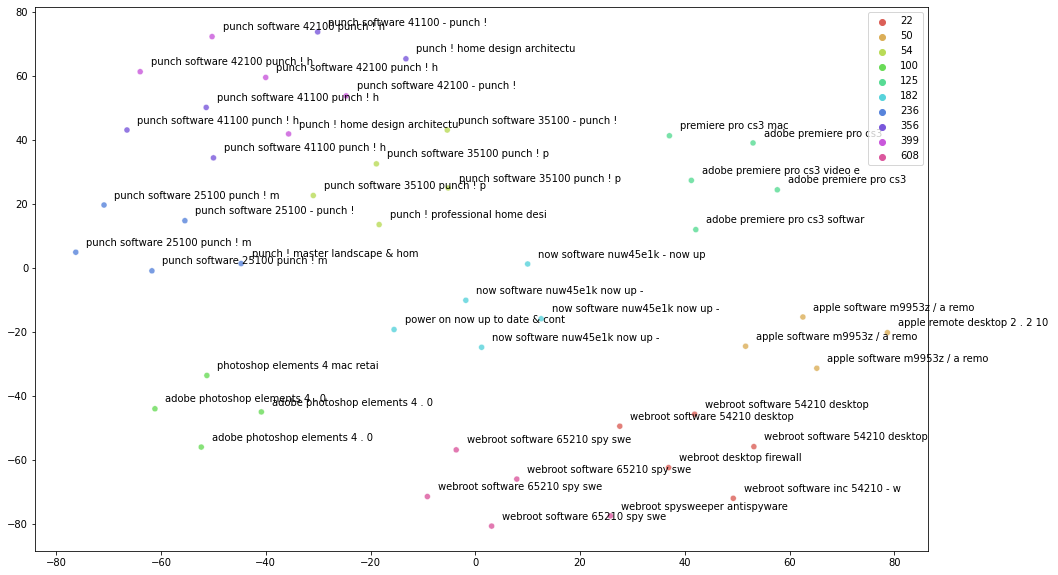

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_row_dict[id_]['name'][:30]
    ax.text(x + 2, y + 2, text)